In [1]:
import keras
import numpy as np
from keras.preprocessing import image
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras import backend

Using TensorFlow backend.


In [2]:
try:
    from tensorflow.python.util import module_wrapper as deprecation
except ImportError:
    from tensorflow.python.util import deprecation_wrapper as deprecation
deprecation._PER_MODULE_WARNING_LIMIT = 0

## Dataset & Visualize
First let's load in the data I've collected from the program. I will use kera's ImageDataGenerator to not only label the data from the directories but also to slightly augment the data with shifts, rotations, zooms, and mirroring. Mirroring will help to ensure that the data are not biased to a particular handedness.

<class 'PIL.PngImagePlugin.PngImageFile'>
(200, 200, 3)


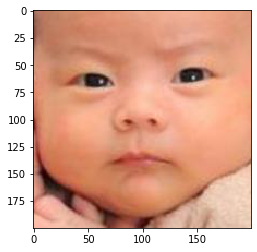

In [3]:
pic = Image.open('Dataset/train/001/1000.png')
print(type(pic))
pic_arr = np.asarray(pic)
print(pic_arr.shape)
plt.imshow(pic_arr)

In [4]:
nbatch = 64
i_size = 140
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10.,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('Dataset/train',
                                                 target_size=(i_size,i_size),
                                                 batch_size =nbatch,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('Dataset/val',
                                            target_size=(i_size,i_size),
                                            batch_size =nbatch,
                                            class_mode = 'categorical')

Found 7298 images belonging to 99 classes.
Found 2480 images belonging to 99 classes.


Text(0.5, 0, 'Class')

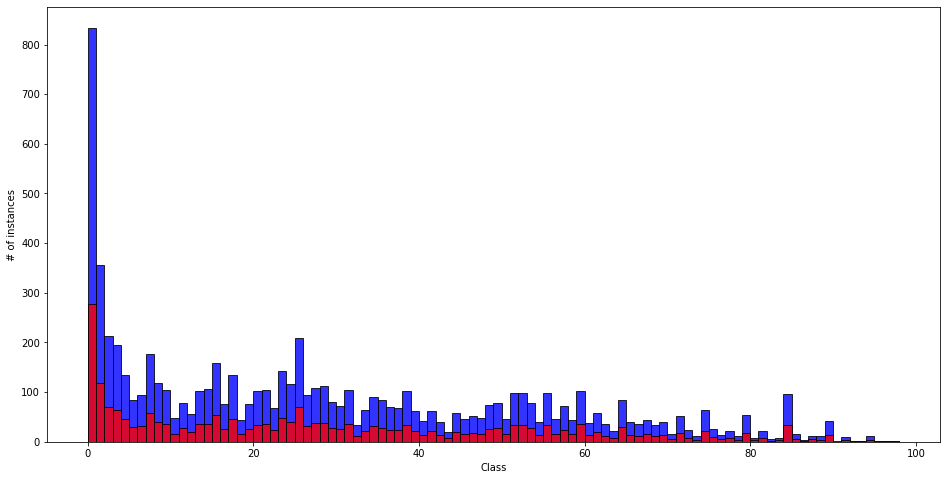

In [5]:
plt.figure(figsize=(16,8))
h1 = plt.hist(training_set.classes, bins=range(0,99), alpha=0.8, color='blue', edgecolor='black')
h2 = plt.hist(test_set.classes,  bins=range(0,99), alpha=0.8, color='red', edgecolor='black')
plt.ylabel('# of instances')
plt.xlabel('Class')

(64, 140, 140, 3) (64, 99)


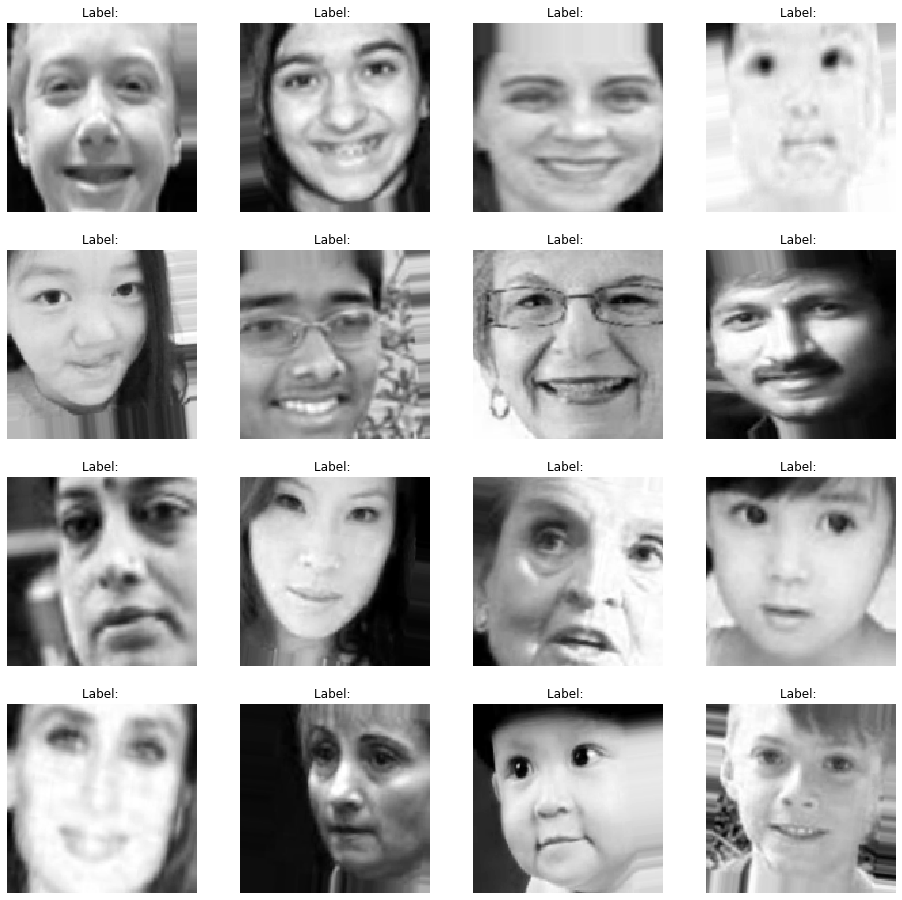

In [6]:
for X, y in training_set:
    print(X.shape, y.shape)
    plt.figure(figsize=(16,16))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.axis('off')
        plt.title('Label: ')
        img = np.uint8(255*X[i,:,:,0])
        plt.imshow(img, cmap ='gray')
    break

## Convolutional Neural Network by using tensorflow keras
The data looks resonable so now we will define a CNN model to train.

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3),activation=tf.nn.relu,input_shape=(i_size,i_size,3)),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3),activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(128, kernel_size=(3, 3),activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation=tf.nn.relu),
    tf.keras.layers.Dense(1024,activation=tf.nn.relu),
    tf.keras.layers.Dense(99,activation=tf.nn.softmax)
])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 138, 138, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 69, 69, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 67, 67, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 33, 33, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 28800)             0

#### Compile the model

In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(),loss=tf.keras.losses.categorical_crossentropy,metrics=['accuracy'])

## Train the Model
Finally we will train our model using some tensorflow-keras helper functions. We are not doing any hyper-parameter optimization so we will not define a separate testing and validation set. We can however evaluate our model further in real time within the application.

In [10]:
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
    tf.keras.callbacks.ModelCheckpoint(filepath='model_checkpoint.h5', save_weights_only=True, verbose=1)
]

In [11]:
history = model.fit_generator(
        training_set,
        steps_per_epoch=86,
        epochs=40,
        validation_data=test_set,
        validation_steps=28,
        callbacks = callbacks_list
    )

Epoch 1/40
85/86 [============================>.] - ETA: 0s - loss: 4.1967 - accuracy: 0.1054
Epoch 00001: saving model to model_checkpoint.h5
86/86 [==============================] - 46s 534ms/step - loss: 4.1936 - accuracy: 0.1053 - val_loss: 3.9810 - val_accuracy: 0.1211
Epoch 2/40
85/86 [============================>.] - ETA: 0s - loss: 3.9267 - accuracy: 0.1250
Epoch 00002: saving model to model_checkpoint.h5
86/86 [==============================] - 47s 547ms/step - loss: 3.9249 - accuracy: 0.1254 - val_loss: 3.7638 - val_accuracy: 0.1373
Epoch 3/40
85/86 [============================>.] - ETA: 0s - loss: 3.7472 - accuracy: 0.1389
Epoch 00003: saving model to model_checkpoint.h5
86/86 [==============================] - 45s 520ms/step - loss: 3.7501 - accuracy: 0.1384 - val_loss: 3.6196 - val_accuracy: 0.1496
Epoch 4/40
85/86 [============================>.] - ETA: 0s - loss: 3.6429 - accuracy: 0.1307
Epoch 00004: saving model to model_checkpoint.h5
86/86 [=========================

Text(0.5, 0, '# of epochs')

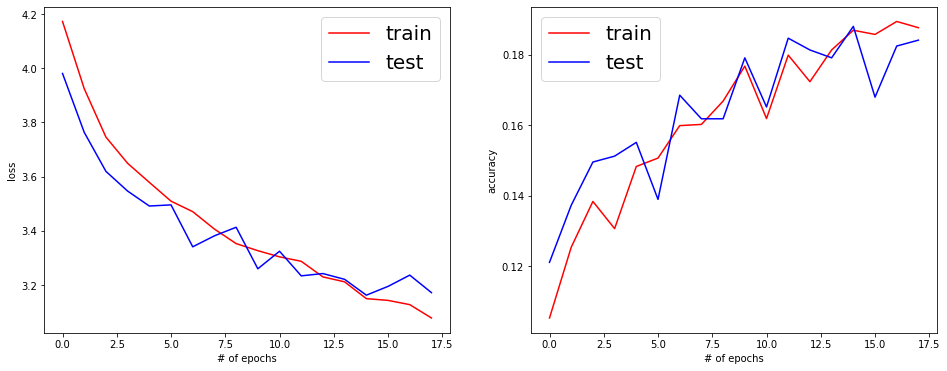

In [14]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
nepochs=len(history.history['loss'])
plt.plot(range(nepochs), history.history['loss'],     'r-', label='train')
plt.plot(range(nepochs), history.history['val_loss'], 'b-', label='test')
plt.legend(prop={'size': 20})
plt.ylabel('loss')
plt.xlabel('# of epochs')
plt.subplot(1,2,2)
plt.plot(range(nepochs), history.history['accuracy'],     'r-', label='train')
plt.plot(range(nepochs), history.history['val_accuracy'], 'b-', label='test')
plt.legend(prop={'size': 20})
plt.ylabel('accuracy')
plt.xlabel('# of epochs')

#### Save the trained model

In [15]:
model.save('my_model.h5') 

## Predections

In [26]:
training_set.class_indices

{'001': 0,
 '002': 1,
 '003': 2,
 '004': 3,
 '005': 4,
 '006': 5,
 '007': 6,
 '008': 7,
 '009': 8,
 '010': 9,
 '011': 10,
 '012': 11,
 '013': 12,
 '014': 13,
 '015': 14,
 '016': 15,
 '017': 16,
 '018': 17,
 '019': 18,
 '020': 19,
 '021': 20,
 '022': 21,
 '023': 22,
 '024': 23,
 '025': 24,
 '026': 25,
 '027': 26,
 '028': 27,
 '029': 28,
 '030': 29,
 '031': 30,
 '032': 31,
 '033': 32,
 '034': 33,
 '035': 34,
 '036': 35,
 '037': 36,
 '038': 37,
 '039': 38,
 '040': 39,
 '041': 40,
 '042': 41,
 '043': 42,
 '044': 43,
 '045': 44,
 '046': 45,
 '047': 46,
 '048': 47,
 '049': 48,
 '050': 49,
 '051': 50,
 '052': 51,
 '053': 52,
 '054': 53,
 '055': 54,
 '056': 55,
 '057': 56,
 '058': 57,
 '059': 58,
 '060': 59,
 '061': 60,
 '062': 61,
 '063': 62,
 '064': 63,
 '065': 64,
 '066': 65,
 '067': 66,
 '068': 67,
 '069': 68,
 '070': 69,
 '071': 70,
 '072': 71,
 '073': 72,
 '074': 73,
 '075': 74,
 '076': 75,
 '077': 76,
 '078': 77,
 '079': 78,
 '080': 79,
 '081': 80,
 '082': 81,
 '083': 82,
 '084': 83,
 '

In [22]:
def ImagePrediction(loc):
    test_image = image.load_img(loc, target_size = (140,140))
    plt.axis('off')
    plt.imshow(test_image)
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis =0)
    result = new_model.predict(test_image)
    print(result.shape)
    print('Prediction: ',result)

Enter Location of Image to predict: D:\Github\Human-Facial-Age-Detection\check.jpg
(1, 99)
Prediction:  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]]


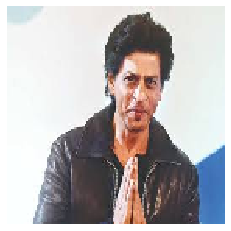

In [25]:
img = input("Enter Location of Image to predict: ")
test_image_1 = ImagePrediction(img)

## Result
Model trained very bad result is not even 25% accurate. And the reason for this greator than age of 5 images dataset is in very less amount also structure, parameters and functions of CNN architecture also need changes 


### I will update this repo again after changes